In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
writer = SummaryWriter('runs/cifar10')

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


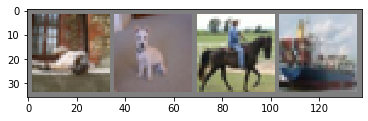

  cat   dog horse  ship


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p = 0.5)
        self.feature_map_conv1 = None
        self.feature_map_conv2 = None

    def forward(self, x):
        x = self.conv1(x)
        self.feature_map_conv1 = x
        x = self.batchnorm1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        self.feature_map_conv2 = x
        x = self.batchnorm2(x)
        x = self.pool(F.relu(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0")

print(device)
net = Net()
net.to(device)

writer.add_graph(net,images.to(device))
writer.close()

cuda:0


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [23]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            
            writer.add_scalar('training loss', running_loss / 200,
                              epoch * len(trainloader) + i)
            
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.881
[1,   400] loss: 1.637
[1,   600] loss: 1.553
[2,   200] loss: 1.444
[2,   400] loss: 1.430
[2,   600] loss: 1.397
[3,   200] loss: 1.315
[3,   400] loss: 1.323
[3,   600] loss: 1.305
[4,   200] loss: 1.269
[4,   400] loss: 1.248
[4,   600] loss: 1.235
[5,   200] loss: 1.183
[5,   400] loss: 1.210
[5,   600] loss: 1.203
[6,   200] loss: 1.177
[6,   400] loss: 1.180
[6,   600] loss: 1.174
[7,   200] loss: 1.154
[7,   400] loss: 1.122
[7,   600] loss: 1.139
[8,   200] loss: 1.130
[8,   400] loss: 1.103
[8,   600] loss: 1.136
[9,   200] loss: 1.096
[9,   400] loss: 1.087
[9,   600] loss: 1.099
[10,   200] loss: 1.079
[10,   400] loss: 1.088
[10,   600] loss: 1.081
Finished Training


In [24]:
feature_map_conv1_grid = torchvision.utils.make_grid(net.feature_map_conv1[0].unsqueeze(dim=1),normalize=True)
writer.add_image('feature_map_conv1', feature_map_conv1_grid)
feature_map_conv2_grid = torchvision.utils.make_grid(net.feature_map_conv2[0].unsqueeze(dim=1),normalize=True)
writer.add_image('feature_map_conv2', feature_map_conv2_grid)

In [25]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [26]:
def test(net, weight_path, testloader):
    net.load_state_dict(torch.load(weight_path))
    device = torch.device("cuda:0")
    net.to(device)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [27]:
net = Net()
test(net, PATH, trainloader)

Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 73 %
Accuracy of   car : 80 %
Accuracy of  bird : 56 %
Accuracy of   cat : 43 %
Accuracy of  deer : 67 %
Accuracy of   dog : 43 %
Accuracy of  frog : 76 %
Accuracy of horse : 64 %
Accuracy of  ship : 70 %
Accuracy of truck : 81 %
